# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


In [92]:
# Added after first cell

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import cross_validate


In [3]:
portfolio


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
transcript.tail(10)


,person,event,value,time
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,{'amount': 25.14},714
306525,eec70ab28af74a22a4aeb889c0317944,transaction,{'amount': 43.58},714
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [5]:
portfolio.shape, profile.shape, transcript.shape


((10, 6), (17000, 5), (306534, 4))

### Cleaning for portfolio dataset


In [6]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
# Now we will create new columns for portfolio dataset which shows us channels seperatly
# We will use it after cleaning all datasets..

channels = ['web','email','mobile','social']

for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)
    

In [8]:
portfolio


,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [9]:
portfolio.drop('channels',axis=1,inplace=True)
portfolio.head()


,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [10]:
pd.get_dummies(portfolio['offer_type'])


,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [11]:
# Duration period is day for portfolio, while hours for transcript
# So I prefer to continue with hours value which can be more detail for our model efficiency.
# Than rename portfolio id column with offer_id, to avoid possible confision.

portfolio['duration']*=24



In [12]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)



In [13]:
portfolio


,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


### Cleaning for profile dataset

In [14]:
# I will encode the user id, It isn't necessery anyway..

In [15]:

def user_mapper():
    coded_dict = dict()
    cter = 1
    user_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        user_encoded.append(coded_dict[val])
    return user_encoded

user_encoded = user_mapper()

profile['user_id'] = user_encoded

# show header
profile.head()


,gender,age,id,became_member_on,income,user_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5


In [16]:
# So we can see that both profile and transaction id's has same amount of users.. 17000
# We can encode the id to user id for both datasets for better understanding
profile.id.nunique(),transcript.person.nunique()


(17000, 17000)

In [17]:
profile.isnull().sum()

# We need to check out if the values for the same users or not..


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
user_id                0
dtype: int64

In [18]:
profile[profile['gender'].isnull()]

# It seems they all the same user id, so we can drop them since we dont have any income or gender data..


,gender,age,id,became_member_on,income,user_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,7
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,8
...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN,16981
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN,16983
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN,16990
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN,16992


In [19]:
profile[profile.age==118]


,gender,age,id,became_member_on,income,user_id
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,1
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,3
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,5
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,7
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,8
...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN,16981
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN,16983
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN,16990
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN,16992


In [20]:
profile_new=profile.dropna()
profile_new.shape


(14825, 6)

In [21]:
profile_new.head()


,gender,age,id,became_member_on,income,user_id
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,4
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,6
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,9
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,13


In [22]:

profile_new['became_member_on'] = pd.to_datetime(profile.became_member_on, format='%Y%m%d')



/Users/alisurmeli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
profile_new.head()


,gender,age,id,became_member_on,income,user_id
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,6
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,9
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,13


In [24]:
# Now we can calculate for how long user is member in starbucks..
# we can assume maximum date as 2019-01-01 and set the membership since as 'member_since_days'


In [25]:
profile_new.became_member_on.max()


Timestamp('2018-07-26 00:00:00')

In [26]:
max_day=pd.to_datetime('20190101', format='%Y%m%d')


In [27]:
profile_new['member_since_days']=(max_day-profile_new.became_member_on).dt.days


/Users/alisurmeli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
profile_new.drop('became_member_on',axis=1, inplace=True)


/Users/alisurmeli/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
# Change 'id' column with 'customer_id' for merging easily 

In [30]:
profile_new.rename(columns={"id": "customer_id"},inplace=True)



/Users/alisurmeli/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
profile_new.head()


,gender,age,customer_id,income,user_id,member_since_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,602
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,6,250
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,9,326
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,13,416


Text(0.5, 0, 'Income')

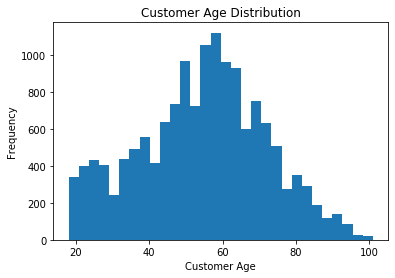

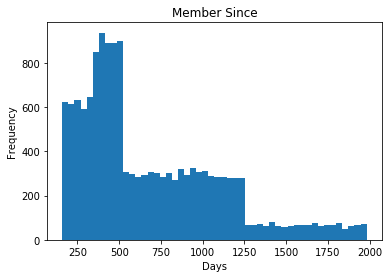

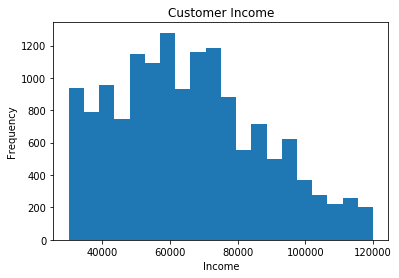

In [32]:
# Customer Age hist
plt.figure()
user_age = profile_new['age'].plot(kind='hist', bins=30, title='Customer Age Distribution')
user_age.set_xlabel("Customer Age")

# Display Histogram of the days being member
plt.figure()
memberdays = profile_new['member_since_days'].plot(kind='hist', bins=50, title='Member Since')
memberdays.set_xlabel("Days")
    
# Display Histogram of User Income
plt.figure()
user_income = profile_new['income'].plot(kind='hist', bins=20, title='Customer Income')
user_income.set_xlabel("Income")


### Cleaning for Transcript dataset

In [33]:
# At first we will create seperated offer_id and amount columns..
# Than drop the value column since we no longer need it
# Rename the person column as customer_id for merging easily
# We have some users who we dont have any information about( age gender etc. ) We will drop that rows
# At last, we will rename transcript dataset as transcript_new for easily future calculations


In [34]:
transcript.head()


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [35]:
transcript['offer_id'] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0] in ['offer_id','offer id'] else None)
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x.keys() else None)


In [36]:
transcript=transcript.drop(columns='value')


In [37]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)



In [38]:
transcript.head()


,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [39]:
transcript.isnull().sum()


customer_id         0
event               0
time                0
offer_id       138953
amount         167581
dtype: int64

In [40]:
# We have 33772 person who we dont have any information about( age gender etc. )

len(transcript)-len(transcript[transcript.customer_id.isin(profile_new.customer_id)])


33772

In [41]:
transcript_new=transcript[transcript.customer_id.isin(profile_new.customer_id)]


In [42]:
transcript_new.duplicated().sum()


374

In [43]:
transcript_new.drop_duplicates(inplace=True)


/Users/alisurmeli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
# It will be more understandable if we change the offer_ids more readable way. So let's encode it.
# And we can rename it like other datasets, portfolio_new..

In [45]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [46]:
portfolio_new=portfolio.copy()

In [47]:
def offer_mapper():
    coded_dict = dict()
    cter = 1
    offer_encoded = []
    
    for val in portfolio_new['offer_id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        offer_encoded.append(coded_dict[val])
    return offer_encoded

offer_encoded = offer_mapper()

for i in range(len(offer_encoded)):
    portfolio_new['offer_id'][i]=str(offer_encoded[i])+'_offer'
    
# show header
portfolio_new.head()


/Users/alisurmeli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,168,bogo,1_offer,0,1,1,1
1,10,10,120,bogo,2_offer,1,1,1,1
2,0,0,96,informational,3_offer,1,1,1,0
3,5,5,168,bogo,4_offer,1,1,1,0
4,5,20,240,discount,5_offer,1,1,0,0


In [48]:
portfolio_new.rename(columns={'offer_id': 'new_offer_id'}, inplace=True)


In [49]:
portfolio_new['offer_id']=portfolio['offer_id']

In [50]:
portfolio_new.head()

,reward,difficulty,duration,offer_type,new_offer_id,web,email,mobile,social,offer_id
0,10,10,168,bogo,1_offer,0,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,120,bogo,2_offer,1,1,1,1,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,96,informational,3_offer,1,1,1,0,3f207df678b143eea3cee63160fa8bed
3,5,5,168,bogo,4_offer,1,1,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,240,discount,5_offer,1,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [51]:
profile_new.head()


,gender,age,customer_id,income,user_id,member_since_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,602
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,6,250
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,9,326
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,13,416


In [52]:
transcript_new.head()


,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [53]:
# Now we have transaction_new, profile_new and portfolio_new datasets..



# LET'S GET TO WORK

In [54]:
# At firts will merge profile&transcript and portfolio&transcript datasets for future usage..


In [55]:
profile_transcript=profile_new.merge(transcript_new, on='customer_id')


In [56]:
profile_transcript.head()


,gender,age,customer_id,income,user_id,member_since_days,event,time,offer_id,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535,transaction,18,None,21.51
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535,transaction,144,None,32.28
2,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535,offer received,504,3f207df678b143eea3cee63160fa8bed,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535,transaction,528,None,23.22


In [57]:
portfolio_transcript=pd.merge(transcript_new,portfolio_new, on='offer_id',how='left')


In [58]:
portfolio_transcript.head()


,customer_id,event,time,offer_id,amount,reward,difficulty,duration,offer_type,new_offer_id,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,168.0,bogo,4_offer,1.0,1.0,1.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,discount,10_offer,1.0,1.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,120.0,bogo,9_offer,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,96.0,informational,3_offer,1.0,1.0,1.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,240.0,discount,5_offer,1.0,1.0,0.0,0.0


In [59]:
portfolio_transcript.event.value_counts()


transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [60]:
# We can see that tx didn't happens or user can't see if offer just receives..
# Now we can drop that particular rows(offer received)
# than create different datasets with all conditions except offer received condition.


In [61]:
portfolio_transcript=portfolio_transcript[portfolio_transcript['event']!='offer received']


In [62]:
offer_viewed=portfolio_transcript[portfolio_transcript['event']=='offer viewed']
offer_completed=portfolio_transcript[portfolio_transcript['event']=='offer completed']
transaction=portfolio_transcript[portfolio_transcript['event']=='transaction']


In [63]:
offer_viewed.head()


,customer_id,event,time,offer_id,amount,reward,difficulty,duration,offer_type,new_offer_id,web,email,mobile,social
11023,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,5.0,120.0,bogo,9_offer,1.0,1.0,1.0,1.0
11024,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0.0,72.0,informational,8_offer,0.0,1.0,1.0,1.0
11025,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,120.0,bogo,2_offer,1.0,1.0,1.0,1.0
11026,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,168.0,bogo,1_offer,0.0,1.0,1.0,1.0
11028,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,0.0,0.0,72.0,informational,8_offer,0.0,1.0,1.0,1.0


In [64]:
offer_completed.head()


,customer_id,event,time,offer_id,amount,reward,difficulty,duration,offer_type,new_offer_id,web,email,mobile,social
11031,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,discount,10_offer,1.0,1.0,1.0,0.0
11042,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,240.0,discount,7_offer,1.0,1.0,1.0,1.0
11048,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,168.0,bogo,4_offer,1.0,1.0,1.0,0.0
11056,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,168.0,bogo,1_offer,0.0,1.0,1.0,1.0
11060,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,120.0,bogo,2_offer,1.0,1.0,1.0,1.0


In [65]:
transaction.head()


,customer_id,event,time,offer_id,amount,reward,difficulty,duration,offer_type,new_offer_id,web,email,mobile,social
11027,02c083884c7d45b39cc68e1314fec56c,transaction,0,None,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,None,34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11032,54890f68699049c2a04d415abc25e717,transaction,0,None,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11040,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,None,19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11041,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,None,18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# Than we will calculate the time of customer became a member when the offer sent to person and between time after receiving and tx happens
# create new columns for this calculations. Name it 'customer_offers' dataframe
# Than merge customer_offers dataset with portfolio new for seeing all datas together..
# After merging, we have no longer need to keep 'offer_id' column which is long and complex data.So we will drop it.

In [67]:
offers = []

offers_viewed = portfolio_transcript[portfolio_transcript.event == 'offer viewed']
offers_completed = portfolio_transcript[portfolio_transcript.event == 'offer completed']
transactions = portfolio_transcript[portfolio_transcript.event == 'transaction']

for index, offer in offers_viewed.iterrows():
    customer_id = offer.customer_id
    start_time = offer.time
    end_time = int(start_time + offer.duration)

    within_time = (transactions.time <= end_time) & (transactions.time >= start_time)
    transaction_amount = transactions[(within_time) & (transactions.customer_id == customer_id)]['amount'].sum()

    within_time = (offers_completed.time <= end_time) & (offers_completed.time >= start_time)
    n_completed = len(offers_completed[(offers_completed.customer_id == customer_id) & (offers_completed.offer_id == offer.offer_id) & within_time])
    
    customer_offer = {
        'customer_id': customer_id,
        'offer_id': offer.offer_id,
        'start_time': start_time,
        'difficulty': offer.difficulty,
        'duration': offer.duration,
        'type': offer.offer_type,
        'reward': offer.reward,
        'web': offer.web,
        'email': offer.email,
        'mobile': offer.mobile,
        'social': offer.social,
        'transaction_amount': transaction_amount,
        'completed': n_completed
        }
    
    offers.append(customer_offer)

customer_offers = pd.DataFrame(offers)


In [68]:
customer_offers.head()

,customer_id,offer_id,start_time,difficulty,duration,type,reward,web,email,mobile,social,transaction_amount,completed
0,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,9.54,1
1,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0,0.0,72.0,informational,0.0,0.0,1.0,1.0,1.0,1.72,0
2,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,120.0,bogo,10.0,1.0,1.0,1.0,1.0,55.07,1
3,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,10.0,168.0,bogo,10.0,0.0,1.0,1.0,1.0,25.49,0
4,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,0.0,72.0,informational,0.0,0.0,1.0,1.0,1.0,15.26,0


In [69]:
portfolio_new.head()

,reward,difficulty,duration,offer_type,new_offer_id,web,email,mobile,social,offer_id
0,10,10,168,bogo,1_offer,0,1,1,1,ae264e3637204a6fb9bb56bc8210ddfd
1,10,10,120,bogo,2_offer,1,1,1,1,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,0,96,informational,3_offer,1,1,1,0,3f207df678b143eea3cee63160fa8bed
3,5,5,168,bogo,4_offer,1,1,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,20,240,discount,5_offer,1,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [70]:
# We can change offer_id's to numeric values for simpler looking, we will merge portfolio_new and customer_offers datasets

In [71]:
customer_offers=customer_offers.merge(portfolio_new[['new_offer_id', 'offer_id']], on='offer_id')


In [72]:
customer_offers.drop('offer_id',axis=1,inplace=True)


In [73]:
customer_offers.head()

,customer_id,start_time,difficulty,duration,type,reward,web,email,mobile,social,transaction_amount,completed,new_offer_id
0,389bc3fa690240e798340f5a15918d5c,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,9.54,1,9_offer
1,262ad0fb526a4d53b572007da60cce24,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,0.00,0,9_offer
2,6d28f18e91324d358d69d1e4b01f1ace,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,548.70,1,9_offer
3,0861b9ca31b741bb8b411b18f82d18f6,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,15.59,1,9_offer
4,fe23d94e175742209abf65cfbc684153,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,13.25,1,9_offer


In [74]:
profile_new.head()

,gender,age,customer_id,income,user_id,member_since_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2,535
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,602
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,6,250
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,9,326
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,13,416


In [75]:
customer_profile=customer_offers.merge(profile_new,on='customer_id')


In [76]:
# We have no longer need to keep customer_id since we have new user id column for this dataset..
customer_profile.drop(['customer_id','user_id'],axis=1,inplace=True)


In [77]:
customer_profile.rename(columns={'new_offer_id': 'offer_id'}, inplace=True)

In [78]:
# OUR DATASET IS READY FOR BUILDING MODEL ON IT. LET'S START BUILDING A MODEL


In [79]:
customer_profile.head()

,start_time,difficulty,duration,type,reward,web,email,mobile,social,transaction_amount,completed,offer_id,gender,age,income,member_since_days
0,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,9.54,1,9_offer,M,65,53000.0,326
1,504,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,11.26,1,9_offer,M,65,53000.0,326
2,354,10.0,168.0,discount,2.0,1.0,1.0,1.0,0.0,15.63,1,10_offer,M,65,53000.0,326
3,192,5.0,168.0,bogo,5.0,1.0,1.0,1.0,0.0,0.00,0,4_offer,M,65,53000.0,326
4,438,5.0,168.0,bogo,5.0,1.0,1.0,1.0,0.0,26.89,1,4_offer,M,65,53000.0,326


### MODEL BUILDING

In [80]:
# We need to split the data to features(X) and target(y) datasets
# We will get dummy variables for X because we have gender offers and type of offer datasets which are need to get dummy variables.
# Set the types as float for all values in columns before fitting to 'standardscaler()' 


In [81]:
X=customer_profile.drop('completed',axis=1)  # Features
y=customer_profile['completed']              # Target


In [82]:
X=pd.get_dummies(X)


In [83]:
X.columns

Index(['start_time', 'difficulty', 'duration', 'reward', 'web', 'email',
       'mobile', 'social', 'transaction_amount', 'age', 'income',
       'member_since_days', 'type_bogo', 'type_discount', 'type_informational',
       'offer_id_10_offer', 'offer_id_1_offer', 'offer_id_2_offer',
       'offer_id_3_offer', 'offer_id_4_offer', 'offer_id_5_offer',
       'offer_id_6_offer', 'offer_id_7_offer', 'offer_id_8_offer',
       'offer_id_9_offer', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [84]:
X['start_time'] = X['start_time'].astype(float)
X['age'] = X['age'].astype(float)
X['member_since_days'] = X['member_since_days'].astype(float)
X['offer_id_1_offer'] = X['offer_id_1_offer'].astype(float)
X['offer_id_2_offer'] = X['offer_id_2_offer'].astype(float)
X['offer_id_3_offer'] = X['offer_id_3_offer'].astype(float)
X['offer_id_4_offer'] = X['offer_id_4_offer'].astype(float)
X['offer_id_5_offer'] = X['offer_id_5_offer'].astype(float)
X['offer_id_6_offer'] = X['offer_id_6_offer'].astype(float)
X['offer_id_7_offer'] = X['offer_id_7_offer'].astype(float)
X['offer_id_8_offer'] = X['offer_id_8_offer'].astype(float)
X['offer_id_9_offer'] = X['offer_id_9_offer'].astype(float)
X['offer_id_10_offer'] = X['offer_id_10_offer'].astype(float)
X['type_bogo'] = X['type_bogo'].astype(float)
X['type_discount'] = X['type_discount'].astype(float)
X['type_informational'] = X['type_informational'].astype(float)
X['gender_F'] = X['gender_F'].astype(float)
X['gender_M'] = X['gender_M'].astype(float)
X['gender_O'] = X['gender_O'].astype(float)

In [85]:
# Now it is time to split the data to train and test split.
# Then build a pipeline for seeing best classification alghorithm..
# We will choose best test score and apply to our data and then analyse it.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Training set sample size is {} .".format(X_train.shape[0]))
print("Testing set sample size is {} .".format(X_test.shape[0]))

Training set sample size is 34902 .
Testing set sample size is 14958 .


In [87]:
clfs = []

pipeline = Pipeline([
    ('normalizer', StandardScaler()), 
    ('clf', KNeighborsClassifier())
]) 

clfs = []
clfs.append(KNeighborsClassifier())
clfs.append(DecisionTreeClassifier(random_state=0))
clfs.append(RandomForestClassifier(n_estimators=100, random_state=0))
clfs.append(GradientBoostingClassifier(random_state=0))
clfs.append(SVC(random_state=0, gamma='scale'))

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, cv=5)
    print('*********')
    print(str(classifier))
    print('*********')
    for key, values in scores.items():
            print(key,' => ', values.mean())

*********
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
*********
fit_time  =>  0.5683526039123535
score_time  =>  8.758870029449463
test_score  =>  0.7867166385715793
*********
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
*********
fit_time  =>  0.29276080131530763
score_time  =>  0.006448793411254883
test_score  =>  0.8235056594464959
*********
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, m

In [88]:
# Best estimators are RandomForestClassifier and GradientBoostingClassifier with %88 estimation percentage
# I prefer to choose RandomForestClassifier for my dataset, so let's build a pipeline with estimator we will determine

In [95]:
from sklearn.model_selection import GridSearchCV


In [150]:
parameters = pipeline.get_params()
parameters


# HERE ARE OUR PARAMETERS WE CAN USE FOR IMPROVING OUR MODEL..

{'memory': None,
 'steps': [('normalizer',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('rfc',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_jobs=None, oob_score=False, random_state=0, verbose=0,
                          warm_start=False))],
 'verbose': False,
 'normalizer': StandardScaler(copy=True, with_mean=True, with_std=True),
 'rfc': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,

In [147]:
pipeline = Pipeline([
    ('normalizer', StandardScaler()), 
    ('rfc', RandomForestClassifier(n_estimators=20, random_state=101,n_jobs=-1,max_features=5,min_sample_split=3))
])             



In [ ]:
# We can find best parameters for better score with using GridSearchCV for RandomForestClassifier
# To do this, after getting parameters of pipeline, we fit the model and get result of best parameters,
# with help of GridSearchCV() and print it. 

parameters = {
         'rfc__n_estimators': [ 10,15,20],
         'rfc__min_samples_split': [3, 4 ],
         'rfc__max_features': [5],
         'rfc__random_state': [101],
         'normalizer__with_mean': [True],
         'rfc__n_jobs': [-1,1]
}

In [148]:
cv=GridSearchCV(estimator=pipeline,param_grid=parameters)
conc=cv.fit(X_train,y_train)

In [149]:
# As we can see, best parameters relaying below cell. We can use this parameters in our model..

print(conc.best_params_)   
#best tunned_ score
print(conc.best_score_)

{'normalizer__with_mean': True, 'rfc__max_features': 5, 'rfc__min_samples_split': 3, 'rfc__n_estimators': 20, 'rfc__n_jobs': -1, 'rfc__random_state': 101}
0.8782302557617504


In [152]:
# But still, our model still has the same accuracy score with %88, but it improved less than %1 rate.
# it was 0.8760 but now it is 0.8843! That's enough for now..
# Even if it is seems a small difference, its effects can be determinant. 

pipeline.fit(X_train, y_train)
print("Test dataset accuracy score = %3.4f" %(pipeline.score(X_test,y_test)))

Test dataset accuracy score = 0.8843


Our model has some missing parts like

## DATA ANALYSIS

## Q1: Which features are most important to prefer which user be chosen?

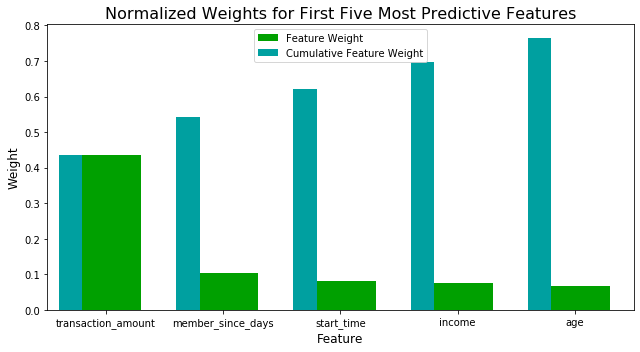

In [756]:
def feature_plot(strength, X_train, y_train):
    
    # Display the five most important features
    indexes = np.argsort(strength)[::-1]
    columns = X_train.columns.values[indexes[:5]]
    values = strength[indexes][:5]

    # Creat the plot
    fig = plt.figure(figsize = (10,6))
    plt.title("Normalized Strength of first 5 Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#EE7621', \
          label = "Feature Strength")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#0000EE', \
          label = "Cumulative Strength")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Strength", fontsize = 12)
    plt.xlabel("Feature Name", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  
    
    
model = RandomForestClassifier(n_estimators=100,random_state=0).fit(X_train, y_train)
strength = model.feature_strength_
feature_plot(strength, X_train, y_train)

It seems like transaction_amount is the most important one having the most predictive power. Membership duration, starting time(suprisely) and income from customer then age follows it.
start_time is the interesting one, maybe this is because offers are valid within a specific period of time and timely transactions matter to achieve completing the offer or not.
Income is an important factor which shows economic power of an individual.



## Q2: Which gender is completing offers the most? and

In [772]:
male_total=len(customer_profile[customer_profile.gender=='M'])
female_total=len(customer_profile[customer_profile.gender=='F'])
other_total=len(customer_profile[customer_profile.gender=='O'])

In [773]:
male_completed=len(customer_profile[(customer_profile.completed == 1) & (customer_profile.gender=='M')])
female_completed=len(customer_profile[(customer_profile.completed == 1) & (customer_profile.gender=='F')])
other_completed=len(customer_profile[(customer_profile.completed == 1) & (customer_profile.gender=='O')])

In [788]:
male_rate=male_completed/male_total
female_rate=female_completed/female_total
other_rate=other_completed/other_total
print('Convertion rate for male customers:',male_rate,'\nConvertion rate for female customers:',female_rate,'\nConvertion rate for other gender customers:',other_rate)

Convertion rate for male customers: 0.40503869121232466 
Convertion rate for female customers: 0.49403444626190707 
Convertion rate for other gender customers: 0.48771021992238034


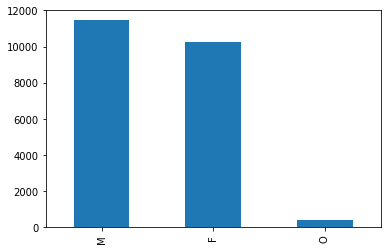

In [754]:
customer_profile[customer_profile.completed == 1].gender.value_counts().plot(kind='bar')

Men are completing offers more than women for total amount. Maybe this is because they drink more or they are more careful on following offers.
But for convertion rate of customers, we can say that female and other gender customers are better and profitable target for Starbucks Company..